# Urban Environmental Noise Classification
This notebook aims to replicate the research presented in the paper titled “Monitoring, profiling and classification of urban environmental noise using sound characteristics and the KNN algorithm”. The main objective is to classify urban environmental noise into different categories using sound-specific features from the time and spectral domains and the K-Nearest Neighbors (KNN) algorithm for classification.

## Importing Libraries
We start by importing the necessary libraries for our task. These include libraries for data manipulation, feature extraction from audio files, and machine learning.

In [ ]:
! pip install numpy pandas librosa scikit-learn keras tensorflow matplotlib seaborn samplerate resampy

In [2]:
import numpy as np
import pandas as pd
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Preprocessing the Metadata
The metadata for our audio files is stored in a CSV file named 'UrbanSound8K.csv'. We will load this data into a pandas DataFrame for easy manipulation. We will also preprocess it to ensure it is in a suitable format for our task.

In [3]:
# Load the metadata from the CSV file
metadata = pd.read_csv('UrbanSound8K.csv')

# Check the first few rows of the DataFrame
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Feature Extraction
The next step is to extract features from the audio files. We will use the librosa library to extract the Mel-frequency cepstral coefficients (MFCCs), Chroma, Mel-scaled Spectrogram, Spectral Contrast, and Tonnetz from each audio file. These features will be used to train our KNN model.

In [4]:
def extract_features(file_name):

    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

        #print("Processing MFCCs")
        # MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)

        #print("Processing Chroma")
        # Chroma
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_scaled = np.mean(chroma.T, axis=0)

        #print("Processing Mel-scaled Spectrogram")
        # Mel-scaled Spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_scaled = np.mean(mel.T, axis=0)

        #print("Processing Spectral Contrast")
        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        contrast_scaled = np.mean(contrast.T, axis=0)

        #print("Processing Tonnetz")
        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate)
        tonnetz_scaled = np.mean(tonnetz.T, axis=0)

        # Concatenate features
        features = np.concatenate([mfccs_scaled, chroma_scaled, mel_scaled, contrast_scaled, tonnetz_scaled])

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}. Exception: {e}")
        return None, False

    return features, True

In [ ]:
# Set the path to the full UrbanSound dataset
fulldatasetpath = 'Data/'

features = []

# Iterate through each sound file and extract the features
numberOfFiles = len(metadata)
counter = 1
for index, row in metadata.iterrows():

    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))

    class_label = row["class"]
    #print(f"---- Processing file {counter}/{numberOfFiles}: {file_name} ----")
    data, successful = extract_features(file_name)
    if(successful):
        features.append([data, class_label])
    counter = counter+1

# Convert into a Panda dataframe
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

featuresdf.to_csv('features.csv', index=True)

print('features.csv saved')

## Preparing the Data for Training
Now that we have extracted the features from our audio files, we can prepare our data for training. This involves converting our categorical labels into numerical labels and splitting our dataset into training and test sets.

In [6]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [7]:
# split the dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

## Model Creation - KNN (N=3)
We will use the K-Nearest Neighbors (KNN) algorithm for our classification task. The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other.
We'll try first the 3 different distance metrics used in the paper

### Euclidean Distance / N=3

In [8]:
knn_n3_euclidean = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_n3_euclidean.fit(x_train, y_train)
predictions_n3_euclidean = knn_n3_euclidean.predict(x_test)

### Chebyshev Distance / N=3

In [9]:
knn_n3_chebyshev = KNeighborsClassifier(n_neighbors=3, metric='chebyshev')
knn_n3_chebyshev.fit(x_train, y_train)
predictions_n3_chebyshev = knn_n3_chebyshev.predict(x_test)

### Cosine Distance / N=3

In [10]:
knn_n3_cosine = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_n3_cosine.fit(x_train, y_train)
predictions_n3_cosine = knn_n3_cosine.predict(x_test)

## Model Creation - KNN (N=5)
We will use the K-Nearest Neighbors (KNN) algorithm for our classification task. The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other.
We'll try first the 3 different distance metrics used in the paper

### Euclidean Distance / N=5

In [11]:
knn_n5_euclidean = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_n5_euclidean.fit(x_train, y_train)
predictions_n5_euclidean = knn_n5_euclidean.predict(x_test)

### Chebyshev Distance / N=5

In [12]:
knn_n5_chebyshev = KNeighborsClassifier(n_neighbors=5, metric='chebyshev')
knn_n5_chebyshev.fit(x_train, y_train)
predictions_n5_chebyshev = knn_n5_chebyshev.predict(x_test)

### Cosine Distance / N=5

In [13]:
knn_n5_cosine = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_n5_cosine.fit(x_train, y_train)
predictions_n5_cosine = knn_n5_cosine.predict(x_test)

## Model Creation - Random Forest
Random Forests are an ensemble learning method that are known for their robustness and ability to avoid overfitting. They work well with a large number of features and can handle non-linear relationships between features, which could be useful given the number of audio features used in this task.

### Number of Trees = 100

In [14]:
# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)

# Train the classifier
clf.fit(x_train, y_train)

# Make predictions on the test set
predictions_rf = clf.predict(x_test)

## Model Creation - CNN

In [15]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Reshape the data to 3D for CNN
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Create a Sequential model
model = Sequential()

# Add a Convolutional layer with 64 filters of size 3
model.add(Conv1D(64, 3, activation='relu', input_shape=(x_train_cnn.shape[1], 1)))

# Add a MaxPooling layer with pool size of 2
model.add(MaxPooling1D(pool_size=2))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a Dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add a Dropout layer for regularization (to prevent overfitting)
model.add(Dropout(0.5))

# Add the output Dense layer with units equal to the number of classes and softmax activation
model.add(Dense(yy.shape[1], activation='softmax'))

# Compile the model with categorical crossentropy loss and an Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model for a given number of epochs
model.fit(x_train_cnn, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test_cnn, y_test))

# Make predictions on the test set
predictions_cnn = model.predict(x_test_cnn)


Epoch 1/10
219/219 [==============================] - 3s 11ms/step - loss: 2.2143 - accuracy: 0.2912 - val_loss: 1.5462 - val_accuracy: 0.4728
Epoch 2/10
219/219 [==============================] - 2s 10ms/step - loss: 1.7056 - accuracy: 0.3838 - val_loss: 1.2933 - val_accuracy: 0.5781
Epoch 3/10
219/219 [==============================] - 2s 10ms/step - loss: 1.5346 - accuracy: 0.4474 - val_loss: 1.1922 - val_accuracy: 0.6045
Epoch 4/10
219/219 [==============================] - 2s 10ms/step - loss: 1.4394 - accuracy: 0.4825 - val_loss: 1.1287 - val_accuracy: 0.6405
Epoch 5/10
219/219 [==============================] - 2s 10ms/step - loss: 1.3813 - accuracy: 0.5005 - val_loss: 1.1157 - val_accuracy: 0.6514
Epoch 6/10
219/219 [==============================] - 2s 10ms/step - loss: 1.3393 - accuracy: 0.5178 - val_loss: 0.9817 - val_accuracy: 0.7098
Epoch 7/10
219/219 [==============================] - 2s 10ms/step - loss: 1.2631 - accuracy: 0.5455 - val_loss: 0.9450 - val_accuracy: 0.7161

## Model Evaluation
We will evaluate our model using a confusion matrix and the classification report, which includes metrics such as precision, recall, and the F1 score.

                                   precision    recall  f1-score      support
CNN              air_conditioner    0.703390  0.817734  0.756264   203.000000
                 car_horn           0.971014  0.779070  0.864516    86.000000
                 children_playing   0.651934  0.644809  0.648352   183.000000
                 dog_bark           0.661290  0.815920  0.730512   201.000000
                 drilling           0.805263  0.742718  0.772727   206.000000
...                                      ...       ...       ...          ...
KNN n3 Euclidean siren              0.922619  0.939394  0.930931   165.000000
                 street_music       0.915789  0.756522  0.828571   230.000000
                 accuracy           0.858615  0.858615  0.858615     0.858615
                 macro avg          0.873135  0.849934  0.854785  1747.000000
                 weighted avg       0.872511  0.858615  0.858957  1747.000000

[104 rows x 4 columns]


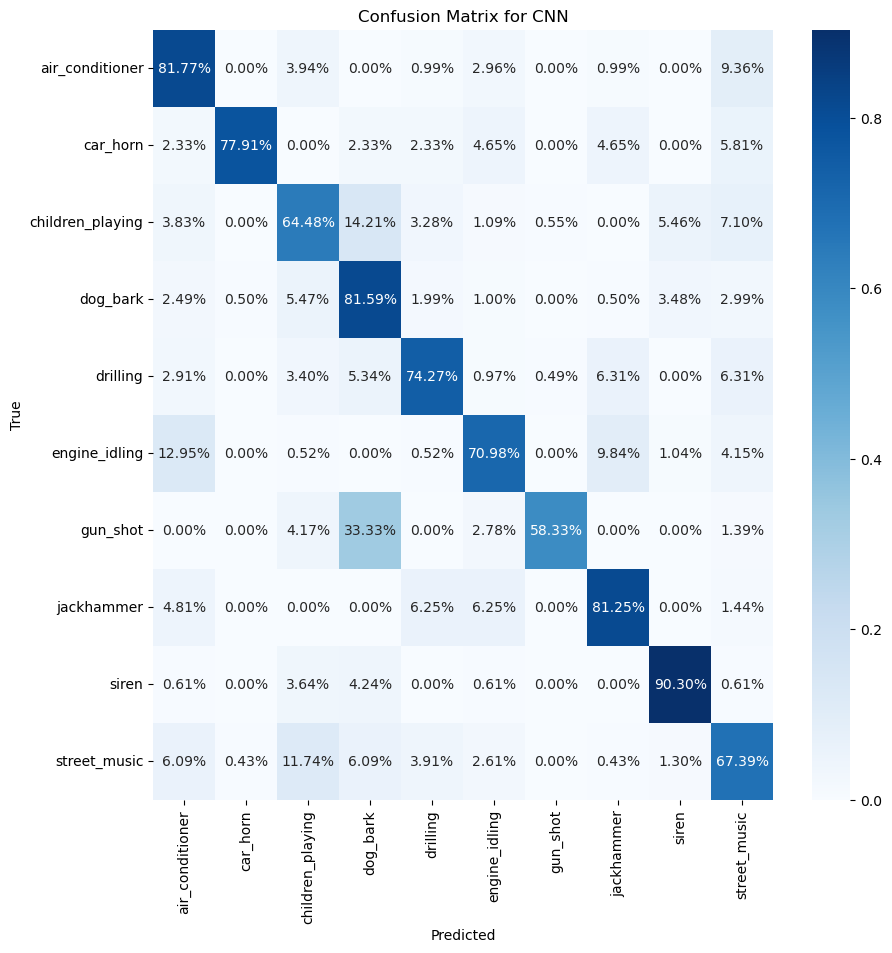

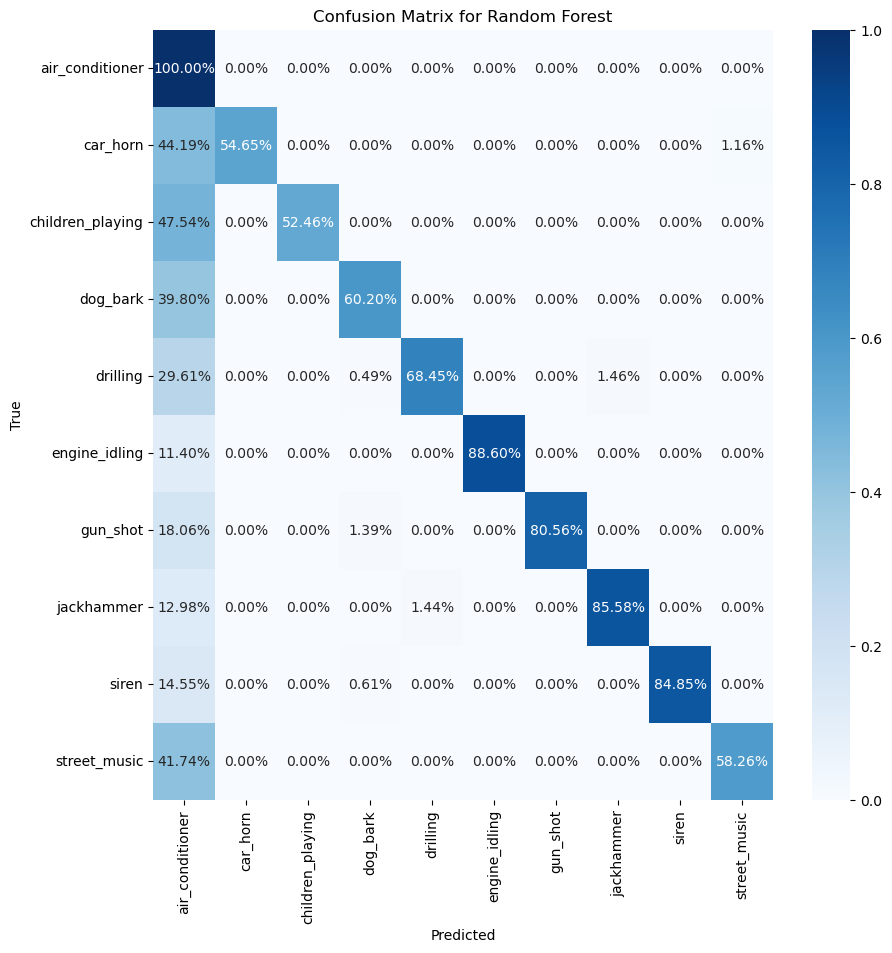

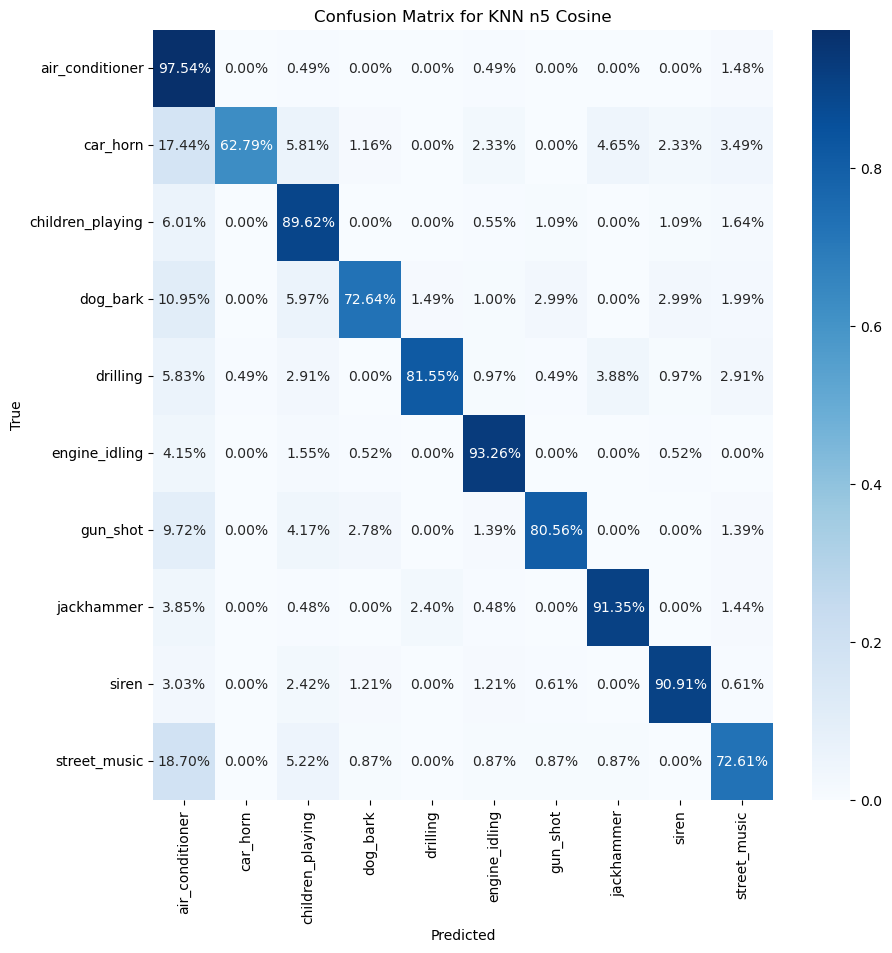

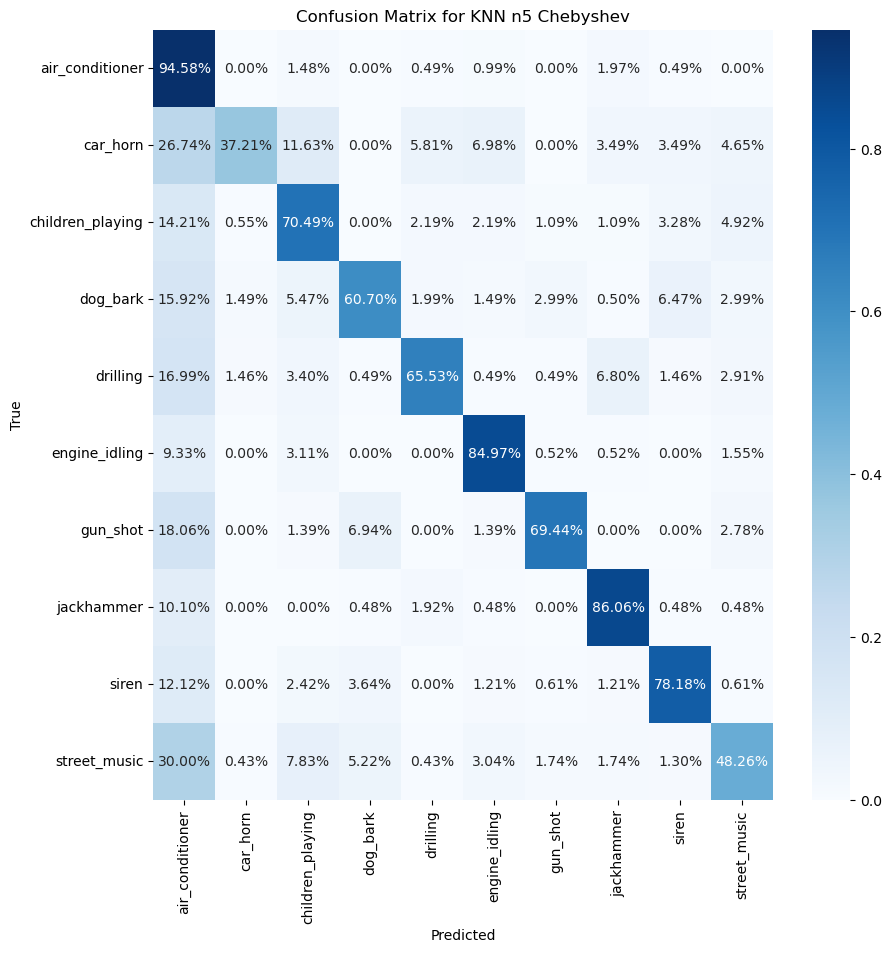

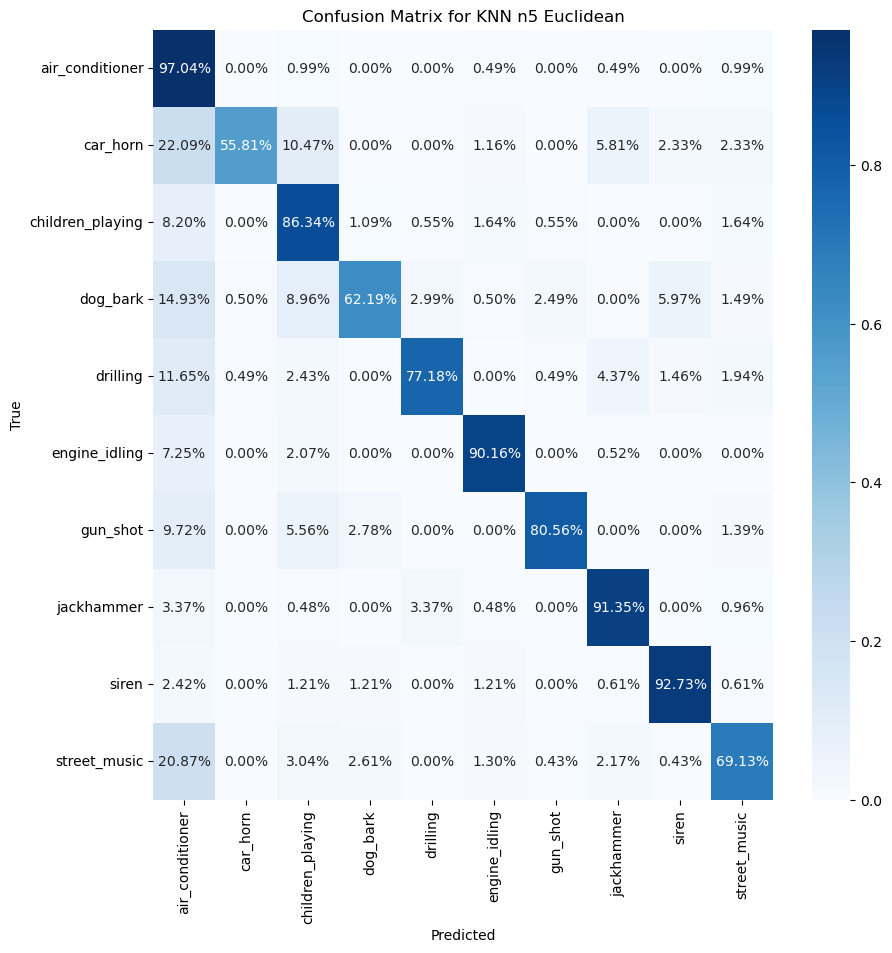

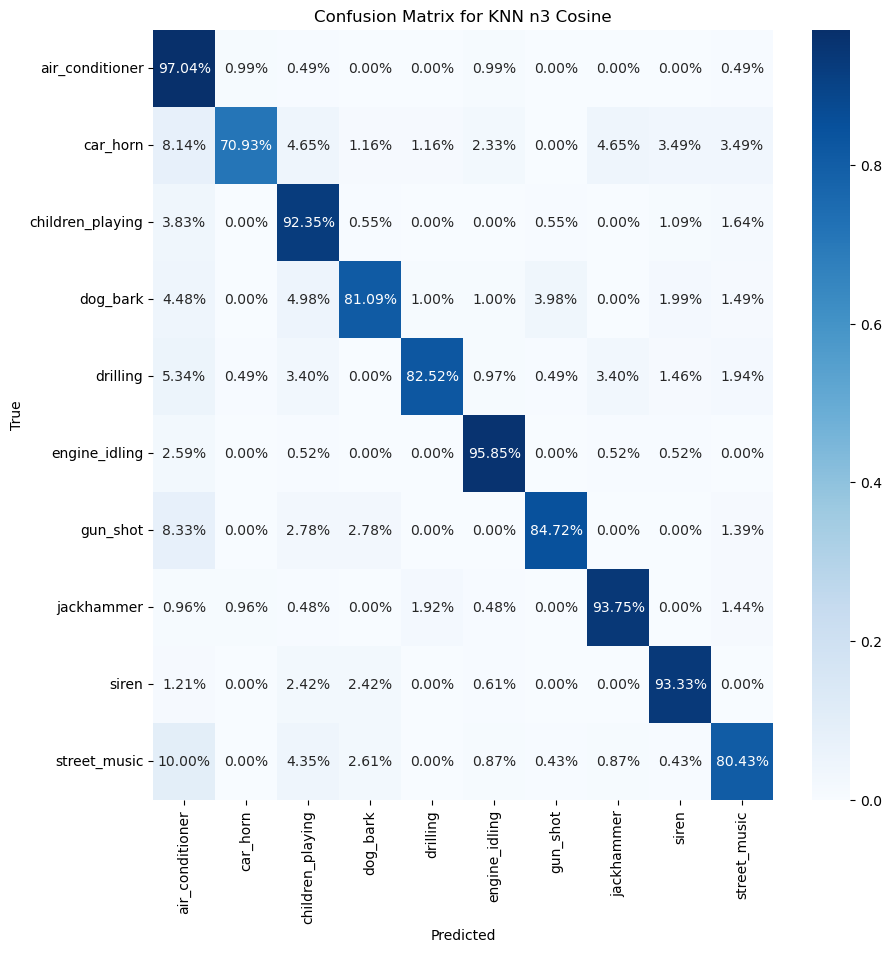

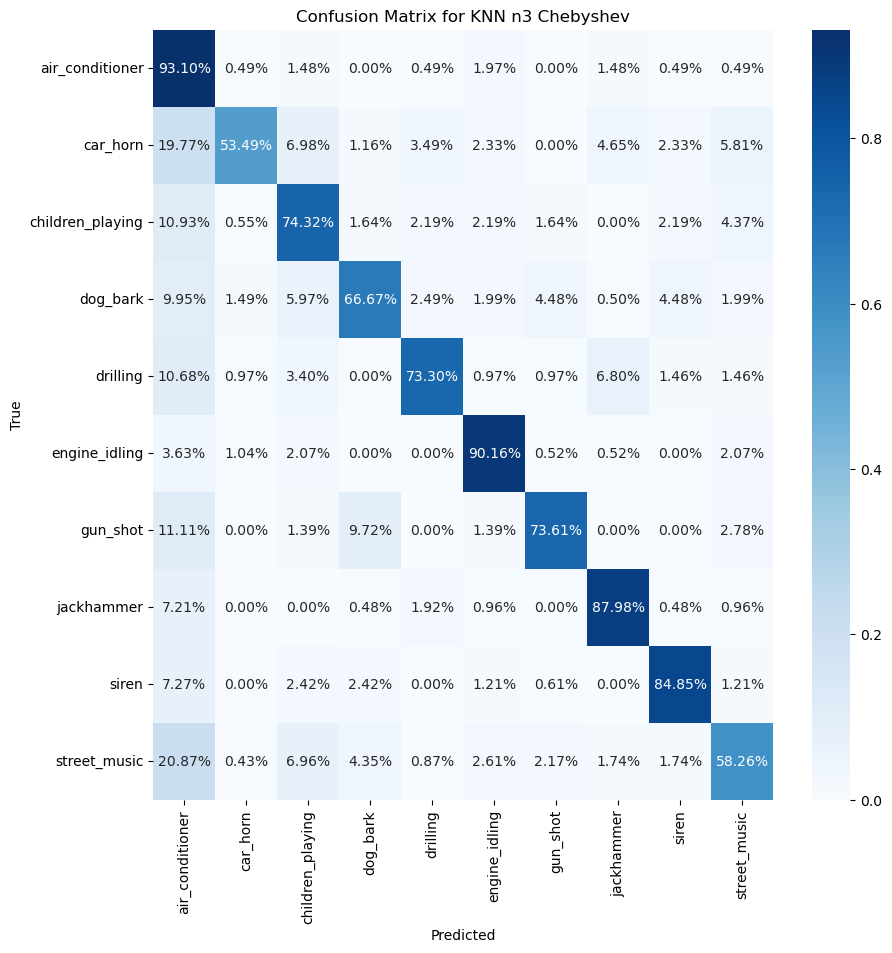

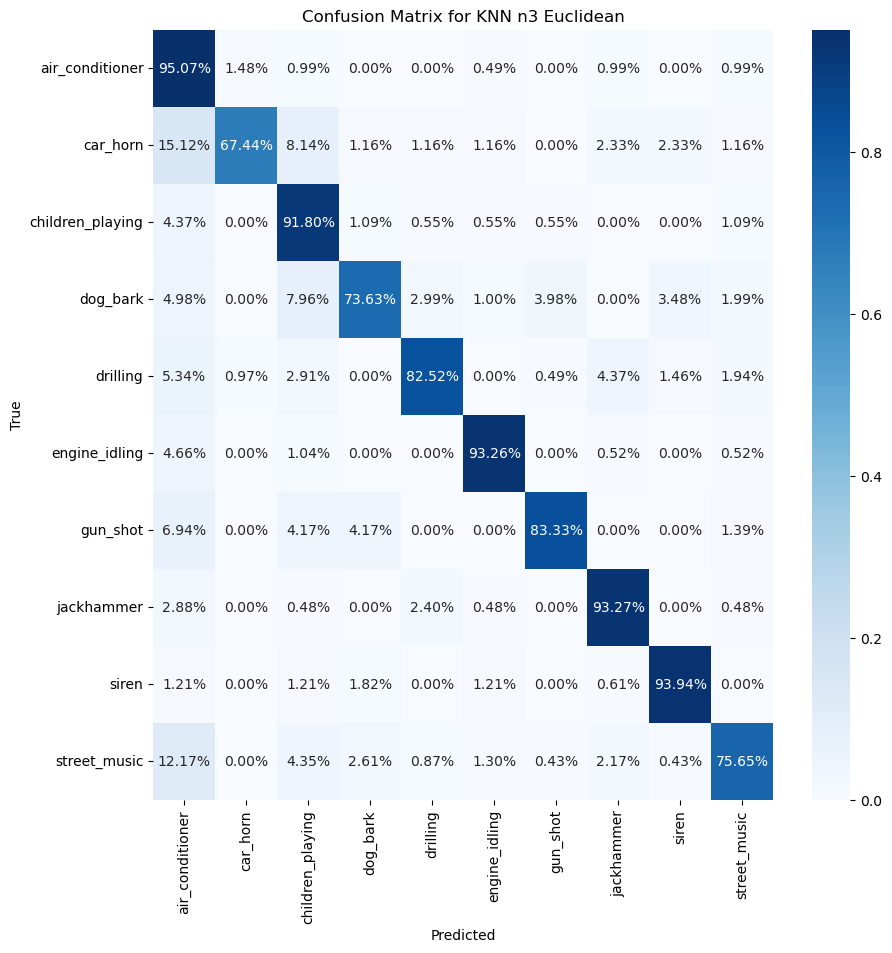

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming y_test are the true labels
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# List of predictions
predictions = [predictions_cnn, predictions_rf, predictions_n5_cosine, predictions_n5_chebyshev, predictions_n5_euclidean, predictions_n3_cosine, predictions_n3_chebyshev, predictions_n3_euclidean]

# List of model names
model_names = ['CNN', 'Random Forest', 'KNN n5 Cosine', 'KNN n5 Chebyshev', 'KNN n5 Euclidean', 'KNN n3 Cosine', 'KNN n3 Chebyshev', 'KNN n3 Euclidean']

# Empty list to store performance metrics
performance_metrics = []

# Convert y_test back to label format
y_test_labels = np.argmax(y_test, axis=1)

# Iterate over each model's predictions
for pred, model_name in zip(predictions, model_names):
    # Convert predictions back to label format
    pred_labels = np.argmax(pred, axis=1)
    
    # Generate the classification report
    report = classification_report(y_test_labels, pred_labels, target_names=labels, output_dict=True)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_labels, pred_labels)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #plt.show()
    
    # Convert the report dictionary to a DataFrame
    report_df = pd.DataFrame(report).transpose()
    
    # Append the report DataFrame to the list
    performance_metrics.append(report_df)

# Concatenate performance metrics dataframes
performance_df = pd.concat(performance_metrics, keys=model_names)

# Print performance metrics comparison
print(performance_df)
performance_df.to_csv('out.csv', index=True)

# Cross Validation (Experiment)

## 5-Fold Cross Validation Approach
In 5-fold cross-validation, the data is divided into 5 equal parts, or "folds". The model is then trained 5 times, each time using 4 folds for training and the remaining fold for testing. This means that each data point is used in the test set exactly once, and in the training set 4 times. The final performance is then the average performance across the 5 test folds.

In [17]:
from sklearn.model_selection import cross_val_score

# Prepare models
models = []
models.append(('RF', RandomForestClassifier(n_estimators=100))) 
models.append(('KNN-3-Euclidean', KNeighborsClassifier(n_neighbors=3, metric='euclidean')))  
models.append(('KNN-3-Cosine', KNeighborsClassifier(n_neighbors=3, metric='cosine')))  
models.append(('KNN-3-Chebyshev', KNeighborsClassifier(n_neighbors=3, metric='chebyshev')))  
models.append(('KNN-5-Euclidean', KNeighborsClassifier(n_neighbors=5, metric='euclidean')))  
models.append(('KNN-5-Cosine', KNeighborsClassifier(n_neighbors=5, metric='cosine')))  
models.append(('KNN-5-Chebyshev', KNeighborsClassifier(n_neighbors=5, metric='chebyshev')))  
# Evaluate each model with 10-fold cross validation
results_5F = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = cross_val_score(model, X, yy, cv=5, scoring=scoring)
    results_5F.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.208998 (0.023009)
KNN-3-Euclidean: 0.320889 (0.019684)
KNN-3-Cosine: 0.341044 (0.017902)
KNN-3-Chebyshev: 0.287330 (0.022626)
KNN-5-Euclidean: 0.306918 (0.017072)
KNN-5-Cosine: 0.328905 (0.018259)
KNN-5-Chebyshev: 0.275190 (0.029775)


## 10-Fold Cross Validation Approach
In 10-fold cross-validation, the data is divided into 10 equal parts, or "folds". The model is then trained 10 times, each time using 9 folds for training and the remaining fold for testing. This means that each data point is used in the test set exactly once, and in the training set 9 times. The final performance is then the average performance across the 10 test folds.

In [18]:
from sklearn.model_selection import cross_val_score

# Prepare models
models = []
models.append(('RF', RandomForestClassifier(n_estimators=100))) 
models.append(('KNN-3-Euclidean', KNeighborsClassifier(n_neighbors=3, metric='euclidean')))  
models.append(('KNN-3-Cosine', KNeighborsClassifier(n_neighbors=3, metric='cosine')))  
models.append(('KNN-3-Chebyshev', KNeighborsClassifier(n_neighbors=3, metric='chebyshev')))  
models.append(('KNN-5-Euclidean', KNeighborsClassifier(n_neighbors=5, metric='euclidean')))  
models.append(('KNN-5-Cosine', KNeighborsClassifier(n_neighbors=5, metric='cosine')))  
models.append(('KNN-5-Chebyshev', KNeighborsClassifier(n_neighbors=5, metric='chebyshev')))  
# Evaluate each model with 10-fold cross validation
results_10F = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = cross_val_score(model, X, yy, cv=10, scoring=scoring)
    results_10F.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.227322 (0.049290)
KNN-3-Euclidean: 0.328343 (0.066470)
KNN-3-Cosine: 0.354107 (0.060545)
KNN-3-Chebyshev: 0.294785 (0.047882)
KNN-5-Euclidean: 0.321699 (0.061218)
KNN-5-Cosine: 0.348266 (0.060414)
KNN-5-Chebyshev: 0.280242 (0.047120)


## 20-Fold Cross Validation Approach
In 20-fold cross-validation, the data is divided into 20 equal parts, or "folds". The model is then trained 20 times, each time using 19 folds for training and the remaining fold for testing. This means that each data point is used in the test set exactly once, and in the training set 19 times. The final performance is then the average performance across the 20 test folds.

In [19]:
from sklearn.model_selection import cross_val_score

# Prepare models
models = []
models.append(('RF', RandomForestClassifier(n_estimators=100))) 
models.append(('KNN-3-Euclidean', KNeighborsClassifier(n_neighbors=3, metric='euclidean')))  
models.append(('KNN-3-Cosine', KNeighborsClassifier(n_neighbors=3, metric='cosine')))  
models.append(('KNN-3-Chebyshev', KNeighborsClassifier(n_neighbors=3, metric='chebyshev')))  
models.append(('KNN-5-Euclidean', KNeighborsClassifier(n_neighbors=5, metric='euclidean')))  
models.append(('KNN-5-Cosine', KNeighborsClassifier(n_neighbors=5, metric='cosine')))  
models.append(('KNN-5-Chebyshev', KNeighborsClassifier(n_neighbors=5, metric='chebyshev')))  
# Evaluate each model with 10-fold cross validation
results_20F = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = cross_val_score(model, X, yy, cv=20, scoring=scoring)
    results_20F.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.239441 (0.055774)
KNN-3-Euclidean: 0.345728 (0.089754)
KNN-3-Cosine: 0.370689 (0.082533)
KNN-3-Chebyshev: 0.305297 (0.071636)
KNN-5-Euclidean: 0.337143 (0.087368)
KNN-5-Cosine: 0.362553 (0.085253)
KNN-5-Chebyshev: 0.289726 (0.068542)
